In [85]:
import numpy as np
import math
import struct
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline

## Constants

In [289]:
sample_rate = 1e6

Make sure data is in float32

In [290]:
stuff=np.fromfile('./rx_bits.txt',dtype='float32')
#header=np.fromfile('./header.dat',dtype='float32')
header = generate_white_noise(seed=4)
footer = generate_white_noise(seed=5)

Take real and imaginary parts of complex signal

In [291]:
arr1 = stuff[::2]
arr2 = stuff[1::2]

Make a complex signal

In [292]:
signal=arr1+(1j * arr2 )

Real signal plot

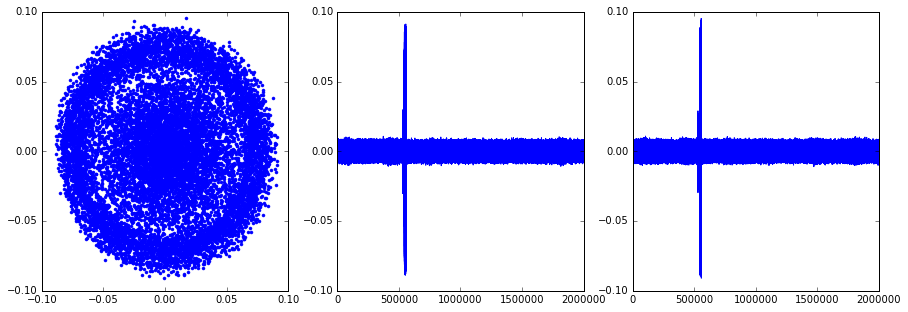

In [293]:
fullPlot(signal)

Calculate the frequency axis of the fft, then calculate the fft of the signal squared. Half of the frequency of the spike is an approximation of the frequency offset.

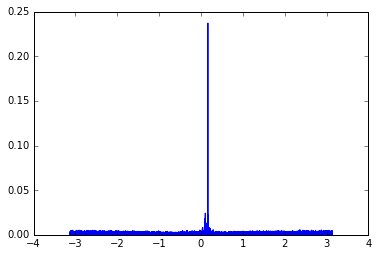

In [294]:
freq_data=np.fft.fftshift(np.fft.fft(signal**4))
freq_axis=np.fft.fftfreq(len(signal),(1/sample_rate))
rad_axis= np.linspace(-np.pi, np.pi*(len(signal)-1)/len(signal), len(freq_data))
plt.plot(rad_axis,np.absolute(freq_data))

In [295]:
freq_offset=np.argmax(freq_data)/4
print("The frequency offset is {:06.2f} hertz".format(freq_axis[np.argmax(freq_data)]/4))
offset = rad_axis[np.argmax(freq_data)]/4
print("The frequency offset is {:06.5f} radians".format(offset))

The frequency offset is -118418.21 hertz
The frequency offset is 0.04135 radians


(0.236944098164-0.00605728891454j)


/home/jwb/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


start: 544932
end: 553132


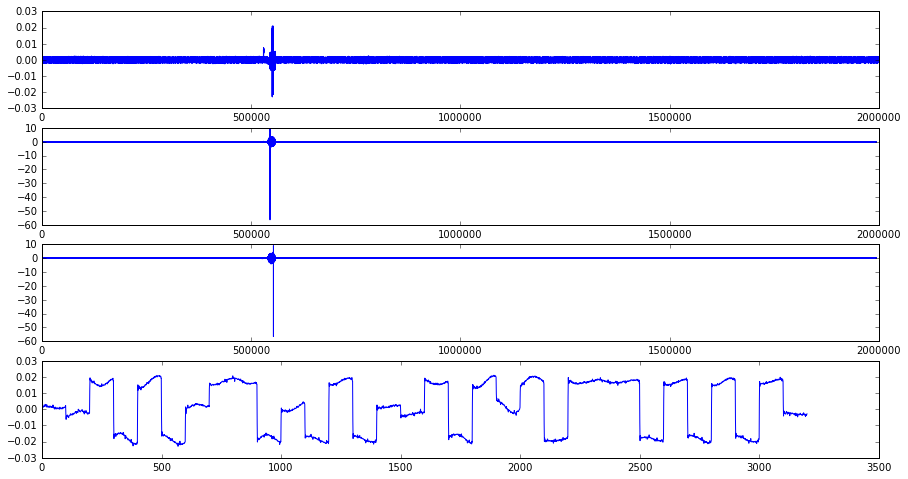

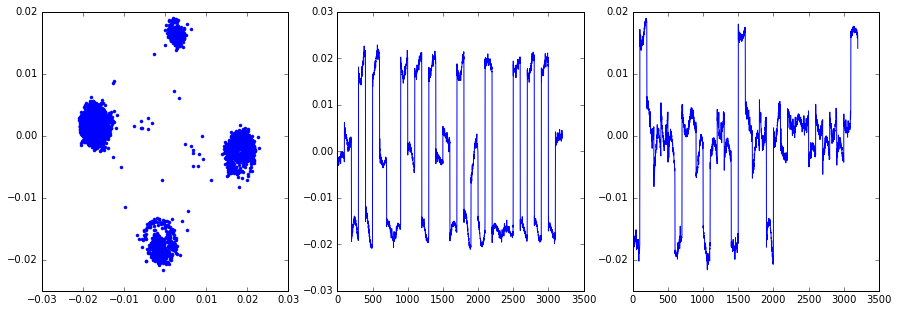

In [296]:
trimmed = autoTrim(signal,header,footer) * -1
fullPlot(trimmed)

### Costas Loop
To correct for phase drift, the Costas loop uses the area of the rectangle formed by our complex vector as an error function. We're not actually using a Costas loop, since we can get a more exact phase correction using nonlinear python operations. 

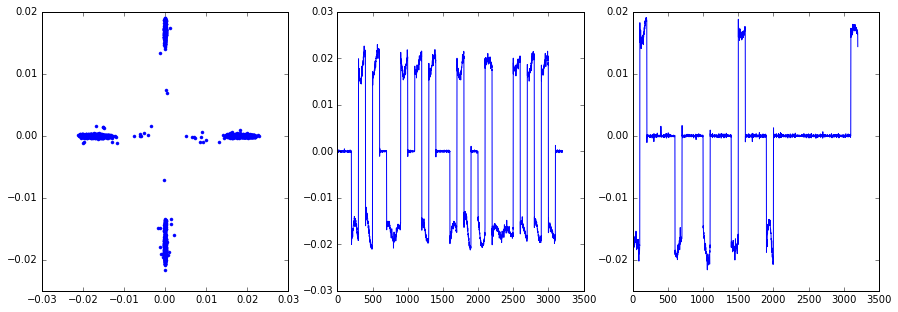

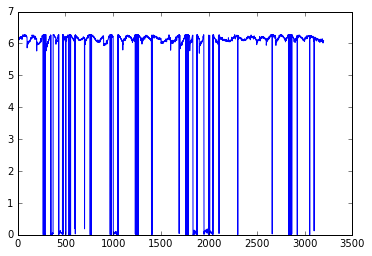

In [297]:
phase_captured, phase_o = phaseCapture(trimmed)
fullPlot(phase_captured)
plt.plot(phase_o)

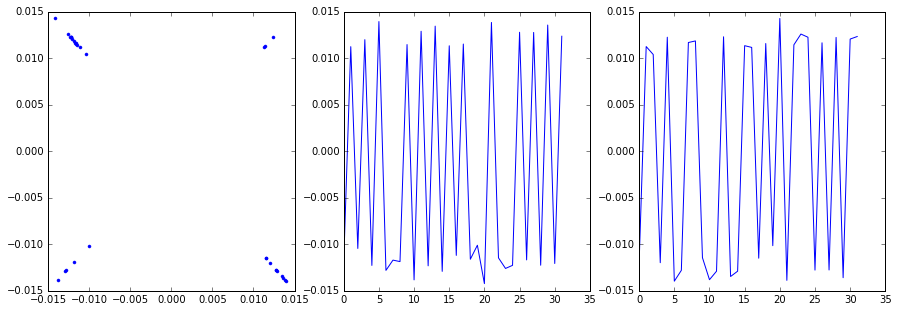

In [298]:
sampled=sample(phase_captured)
res = sampled*np.exp(-1j*np.pi/4)
fullPlot(res)

In [299]:
expectation=[0, 3, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 3, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3]

In [300]:
received_bits = list(parse(res, threshold=.001))
if len(expectation) != len(received_bits):
    print('padding')
    print(len(expectation),len(received_bits))
    expectation = [-1] * np.absolute(len(received_bits)-len(expectation)) + expectation

# print(expectation)
error = [bin(a^b).count("1") for a,b in zip(expectation, received_bits)]
print(error)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [301]:
print(received_bits)

[0, 3, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 3, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3]


In [302]:
print(expectation)

[0, 3, 1, 2, 1, 2, 0, 1, 1, 2, 0, 2, 1, 2, 0, 3, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 3]


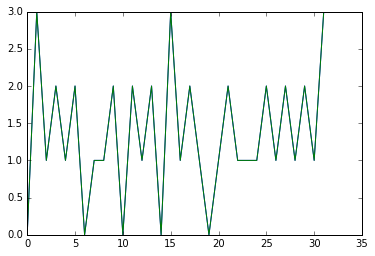

In [303]:
plt.plot(expectation)
plt.plot(received_bits)

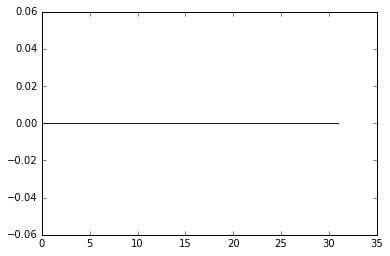

In [304]:
plt.plot(error)

## Functions

In [112]:
def approxPhaseCorrect(raw_sig,rate=sample_rate,verbose=False):
    """Applies a approximate phase correction to a complex signal, returning the corrected signal"""
    duration = len(raw_sig)
    freq_data = np.fft.fftshift(np.fft.fft(raw_sig**4))
    rad_axis= np.linspace(-np.pi, np.pi*(duration-1)/duration, len(freq_data))
    if verbose:
        pass
    peak = np.argmax(freq_data)
    print(freq_data[peak])
    offset = rad_axis[peak]/4
    correction = -np.exp(-1j*np.linspace(0,duration-1,duration)*offset)
    return raw_sig*correction*freq_data[peak]

def generate_white_noise(seed=None):
    mean = 0
    std = 1
    num_samples = 5000
    np.random.seed(seed)
    samples = np.random.normal(mean, std, size=num_samples)
    header=samples + (1j * samples)
    return header

In [109]:
def argand(signal):
    """Plots an argand diagram of a complex signal"""
    plt.plot(np.real(signal),np.imag(signal), marker='.',linestyle='')
    
def fullPlot(signal):
    """Plots an argand diagram of a complex signal, along with the real and complex components in time"""
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    argand(signal)
    
    plt.subplot(132)
    plt.plot(np.real(signal))
    
    plt.subplot(133)
    plt.plot(np.imag(signal))
    
    plt.show()

In [236]:
def autoTrim(raw_signal, header, footer):
    signal = approxPhaseCorrect(raw_signal)
    header_corr = np.correlate(signal, header, mode="valid")
    footer_corr = np.correlate(signal, footer, mode="valid")
    start_time = np.argmax(np.absolute(header_corr))
    end_time = np.argmax(np.absolute(footer_corr))
    trimmed = signal[start_time+len(header):end_time]
    
    plt.figure(figsize=(15,8))
    plt.subplot(411)
    plt.plot(np.real(signal))
    plt.subplot(412)
    plt.plot(np.real(header_corr))
    plt.subplot(413)
    plt.plot(np.real(footer_corr))
    plt.subplot(414)
    plt.plot(trimmed)

    print("start: {}".format(start_time))
    print("end: {}".format(end_time))
    
    return trimmed

In [32]:
def parse(signal, threshold=0.05):
    for sample in signal:
        if np.absolute(np.real(sample))+np.absolute(np.imag(sample)) < threshold:
            yield(-1)
            continue
        if np.real(sample) < 0:
            if np.imag(sample) < 0:
                yield(0)
            else:
                yield(1)
        else:
            if np.imag(sample) < 0:
                yield(2)
            else:
                yield(3)

In [33]:
def sample(signal, offset=40, bucket=20, period=100):
    length = len(signal)
    num_pads = int(period * np.ceil(length/period))-length
#     pads = (int(np.floor(num_pads/2)), int(np.ceil(num_pads/2)))
    signal_padded = np.pad(signal, (0,num_pads), 'constant', constant_values=np.NaN)
    signal_reshaped = np.reshape(signal_padded, (-1, period))
    signal_sliced = signal_reshaped[:, range(offset, offset+bucket+1)]
    signal_mean = np.nanmean(signal_sliced, axis=1)
    return signal_mean

In [279]:
def phaseCapture(signal):
    phase_captured = []
    phase_offset_t = []
    phase_offset = 0
    corrected_sample = 0
    avg_mag = np.mean([np.absolute(p) for p in signal])
    
    for point in signal:
        if np.absolute(point) > 0.25 * avg_mag:
            # apply previous correction factor
            corrected_sample = point * np.exp(-1j*phase_offset)

            received_angle = np.angle(corrected_sample) # range from -pi to pi
            received_angle += 2 * np.pi # Correct to range of 0 to 2 pi

            #calculate multiples of pi/2 the received was offset from 0
            num_quadrants = np.floor((received_angle + np.pi / 4) / (np.pi / 2) )
            original_angle = np.pi * num_quadrants / 2

            #calculate received angle offset from intended angle
            measured_offset = received_angle - original_angle
            
        # add forgetting factor
        phase_offset = phase_offset + 0.8 * measured_offset
        
        # wrap phase_offset from 0 to -2 pi
        while (phase_offset > 2 * np.pi):
            phase_offset = phase_offset - 2 * np.pi
        while (phase_offset < 0):
            phase_offset = phase_offset + 2 * np.pi

        #apply final correction factor and output
        phase_captured.append(point * np.exp(-1j*phase_offset))
        phase_offset_t.append(phase_offset)
    
    return phase_captured, phase_offset_t